Visualize given stocks

(array([19555.58333333, 19555.625     , 19555.66666667, 19555.70833333,
        19555.75      , 19555.79166667, 19555.83333333]),
 [Text(19555.583333333332, 0, '07-17 10'),
  Text(19555.625, 0, '07-17 11'),
  Text(19555.666666666668, 0, '07-17 12'),
  Text(19555.708333333332, 0, '07-17 13'),
  Text(19555.75, 0, '07-17 14'),
  Text(19555.791666666668, 0, '07-17 15'),
  Text(19555.833333333332, 0, '07-17 16')])

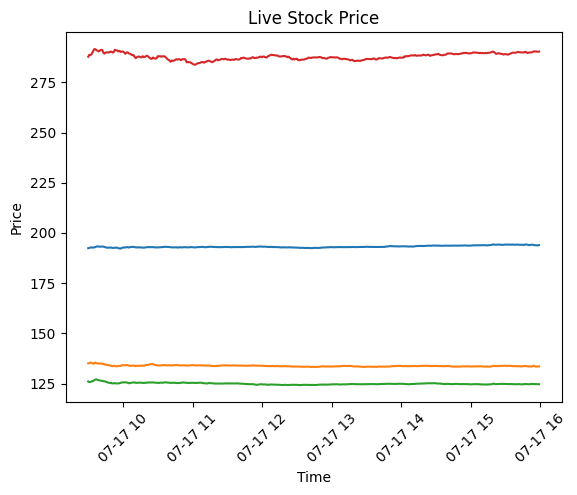

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf

# stocks to visualize and forecast
tickers = ['AAPL', 'GOOGL', 'AMZN', 'TSLA']

# fetch stock data
stockData = yf.download(tickers=tickers, period='id', interval='1m')

# create plot
plt.plot(stockData['Close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Live Stock Price')
plt.xticks(rotation=45)

Forecast Stock Prices

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import accuracy_score
import yfinance as yf
import numpy as np

# fetch, reshape and normalize historical data
tickers = ['AAPL', 'GOOGL', 'AMZN', 'TSLA']
histData = yf.download(tickers=tickers, period='id', interval='1m')
scaler = MinMaxScaler()
normalized_stockData = scaler.fit_transform(histData)

# Features
X = normalized_stockData[:, :-1]
X.reshape(-1, 1, 389)

# stock prices (target variable)
y = normalized_stockData[:, -1]
y.reshape(-1, 1, 389)

# split into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform feature selection with L1 Regularization
selection = Lasso(alpha=0.05)
selection.fit(X_train, y_train)
selectedFeatures = selection.coef_

# create and compileLSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(1, X.shape[0])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs = 10, batch_size = 32)

# perform prediction
new_normalizedData = scaler.transform(normalized_stockData)
newX = np.reshape(new_normalizedData, (new_normalizedData.shape[0], 1, new_normalizedData.shape[1]))
predictions = model.predict(newX)

# evaluate model
accuracy = accuracy_score(y_true=y_test, y_pred=model.predict(X_test))
print(accuracy)


[*********************100%***********************]  4 of 4 completed
Epoch 1/10


ValueError: in user code:

    File "c:\Users\davis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1376, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\davis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1359, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\davis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1348, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\davis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1125, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\davis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\davis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 1, 389), found shape=(None, 23)
